# Facial Expression Recognition

Steps:
    1. Importing the libraries and reading the CSV file
    2. Getting the training features X and labels y from pixels
    3. Getting emotion columns of the CSV respectively and converting them into numpy arrays
    
    <b> 4. We have added an additional dimension to our feature vector by using np.expand_dims() function, 
    this is done to make the input suitable for our CNN which we will design later.<b>
    
    5. Both features and labels are stored as .npy files to be used later.

In [6]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv("./fer2013.csv")

width, height = 48, 48

datapoints = data['pixels'].tolist()

#getting features for training
X = []
for point in datapoints:
    img_pnt = [int(i) for i in point.split(' ')]
    img_pnt = np.asarray(img_pnt).reshape(width, height)
    X.append(img_pnt.astype('float32'))

X = np.asarray(X)
X = np.expand_dims(X, -1)

#getting labels for training
y = pd.get_dummies(data['emotion']).as_matrix()

#storing them using numpy
np.save('fdataX', X)
np.save('flabels', y)

print("Preprocessing Done")
print("Number of Features: "+str(len(X[0])))
print("Number of Labels: "+ str(len(y[0])))
print("Number of examples in dataset:"+str(len(X)))
print("X,y stored in fdataX.npy and flabels.npy respectively")

Preprocessing Done
Number of Features: 48
Number of Labels: 7
Number of examples in dataset:35887
X,y stored in fdataX.npy and flabels.npy respectively


Steps:
    1. Importing the required libraries for our CNN
    2. first we declare the variables we will need for training our CNN. 
    3. We have 48x 48-pixel resolution so we have width and height as 48. 
    4. Then we have 7 emotions that we are predicting namely 
    (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral), so we have 7 labels. 
    5. We will be processing our inputs with a batch size of 64
    
    6. we load the features and labels into x and y respectively and 
    standardized x by subtracting the means and dividing by the standard deviation.
    7. The first four lines just print the images by using the pixel values. 
    After that we divide the data into training and testing set by using sklearn’s train_test_split() function 
    and save the test features and labels to be used later. 
    8. We are also performing another division on our training data to obtain the validation data which would be used later in the code.

In [7]:
import sys, os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2

num_features = 64
num_labels = 7
batch_size = 64
epochs = 50
width, height = 48, 48

x = np.load('./fdataX.npy')
y = np.load('./flabels.npy')

x -= np.mean(x, axis=0)
x /= np.std(x, axis=0)

#for xx in range(10):
#    plt.figure(xx)
#    plt.imshow(x[xx].reshape((48, 48)), interpolation='none', cmap='gray')
#plt.show()

#splitting into training, validation and testing data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

#saving the test samples to be used later
np.save('modXtest', X_test)
np.save('modytest', y_test)

This step is the most important part of the entire process as we design the CNN through which we will pass our features to train the model and eventually test it using the test features. We have used a combination of several different functions to construct CNN which we will discuss one by one.

1. Sequential() - A sequential model is just a linear stack of layers which is putting layers on top of each other as we progress from the input layer to the output layer. You can read more about this here.

2. model.add(Conv2D()) - This is a 2D Convolutional layer which performs the convolution operation as described at the beginning of this post. To quote Keras Documentation “ This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs.” Here we are using a 3x3 kernel size and Rectified Linear Unit (ReLU) as our activation function.

3. model.add(BatchNormalization()) - It performs the batch normalization operation on inputs to the next layer so that we have our inputs in a specified scale say 0 to 1 instead of being scattered all over the place.

4. model.add(MaxPooling2D()) - This function performs the pooling operation on the data as explained at the beginning of the post. We are taking a pooling window of 2x2 with 2x2 strides in this model. If you want to read more about MaxPooling you can refer the Keras Documentation or the post mentioned above.

5. model.add(Dropout()) - As explained above Dropout is a technique where randomly selected neurons are ignored during the training. They are “dropped out” randomly. This reduces overfitting.

6. model.add(Flatten()) - This just flattens the input from ND to 1D and does not affect the batch size.

7. model.add(Dense()) - According to Keras Documentation, Dense implements the operation: output = activation(dot(input, kernel)where activationis the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer. In simple words, it is the final nail in the coffin which uses the features learned using the layers and maps it to the label. During testing, this layer is responsible for creating the final label for the image being processed.

In [8]:
#desinging the CNN
model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))


Steps:
    This is a fairly simple chunk of code where first the model is compiled with categorical_crossentropy as the loss function and using Adam optimizer. We are using accuracy as the metrics for validation.
    
Next, we are fitting the model with the fixed batch size (64 here), epochs (100 here) and validation data which we obtained by splitting the training data earlier. 

We can train the network. To complete the training in less time, I prefer to implement learning with randomly selected trainset instances. That is the reason why train and fit generator used. Also, loss function would be cross entropy because the task is multi class classification.

In [9]:
#Compliling the model with adam optimixer and categorical crossentropy loss
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

#training the model
model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_valid), np.array(y_valid)),
          shuffle=True)


Train on 29068 samples, validate on 3230 samples
Epoch 1/50
29068/29068 [==============================] - 3627s 125ms/step - loss: 1.9909 - accuracy: 0.2136 - val_loss: 1.8134 - val_accuracy: 0.2594
Epoch 2/50
29068/29068 [==============================] - 1530s 53ms/step - loss: 1.8238 - accuracy: 0.2492 - val_loss: 1.7618 - val_accuracy: 0.2734
Epoch 3/50
29068/29068 [==============================] - 1542s 53ms/step - loss: 1.7343 - accuracy: 0.2972 - val_loss: 1.6098 - val_accuracy: 0.3427
Epoch 4/50
29068/29068 [==============================] - 1743s 60ms/step - loss: 1.6140 - accuracy: 0.3598 - val_loss: 1.4491 - val_accuracy: 0.4183
Epoch 5/50
29068/29068 [==============================] - 1891s 65ms/step - loss: 1.5147 - accuracy: 0.4063 - val_loss: 1.3770 - val_accuracy: 0.4387
Epoch 6/50
29068/29068 [==============================] - 1854s 64ms/step - loss: 1.4518 - accuracy: 0.4323 - val_loss: 1.3137 - val_accuracy: 0.4907
Epoch 7/50
29068/29068 [==========================

### Confusion Matrix

#### Predicting the labels(emotions) for the test dataset

In [17]:
predictions = model.predict(X_test)

In [18]:
# from sklearn.metrics import classification_report, confusion_matrix
 
# pred_list = []; actual_list = []
 
# for i in predictions:
 
#     pred_list.append(np.argmax(i))
 
# for i in y_test:
 
#     actual_list.append(np.argmax(i))
 
# confusion_matrix(actual_list, pred_list)

#### Calculating the ground truth lables and the predicted labels 

In [19]:
truey=[]
predy=[]

ypred = predictions.tolist()
ytrue = y_test.tolist()
count = 0

for i in range(len(y_test)):
    ypred_index = max(ypred[i])
    ytrue_index = max(ytrue[i])
    predy.append(ypred[i].index(ypred_index))
    truey.append(ytrue[i].index(ytrue_index))
    if(ypred[i].index(ypred_index)== ytrue[i].index(ytrue_index)):
        count+=1

acc = (count/len(y_test))*100

# #saving values for confusion matrix and analysis
# np.save('truey', truey)
# np.save('predy', predy)

Now I also created a confusion matrix to find out which emotions usually get confused with each other more often 

Steps: 
    Lines represent actual values whereas columns state predictions. 
    I mean that there are 467 angry instances in testset. We can classify 214 angry items correctly. 
    On the other hand, we classified 9 items as disgust but these items are actual angry ones.

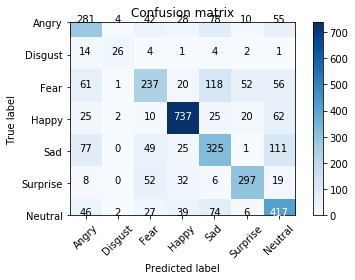

In [20]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(truey, predy)
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
title='Confusion matrix'

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## Testing
Let’s try to recognize facial expressions of custom images. Because only error rates don’t express anything.

### Take an image and save

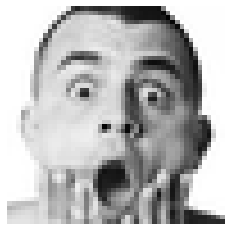

In [21]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from keras.preprocessing.image import save_img
from keras.preprocessing.image import img_to_array

img = data["pixels"][108] # first image
val = img.split(" ")
x_pixels = np.array(val, 'float32')
x_pixels /= 255
x_reshaped = x_pixels.reshape(48,48)

img_array = img_to_array(x_reshaped)
plt.imshow(x_reshaped, cmap= "gray", interpolation="nearest")
plt.axis("off")
plt.show()
save_img('1.jpg', img_array)

Emotions stored as numerical as labeled from 0 to 6. Keras would produce an output array including these 7 different emotion scores. We can visualize each prediction as bar chart.

In [22]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
 
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    plt.show()

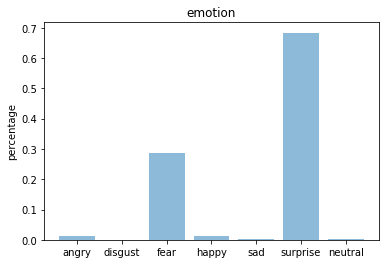

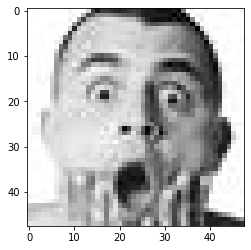

In [23]:
from keras.preprocessing import image
img = image.load_img("./1.jpg", color_mode = "grayscale", target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
 
x /= 255
 
custom = model.predict(x)
emotion_analysis(custom[0])
 
x = np.array(x, 'float32')
x = x.reshape([48, 48]);
 
plt.gray()
plt.imshow(x)
plt.show()